Проект: Диффузия, потоки

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [2]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("data/magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [3]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [4]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [5]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [6]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

In [7]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

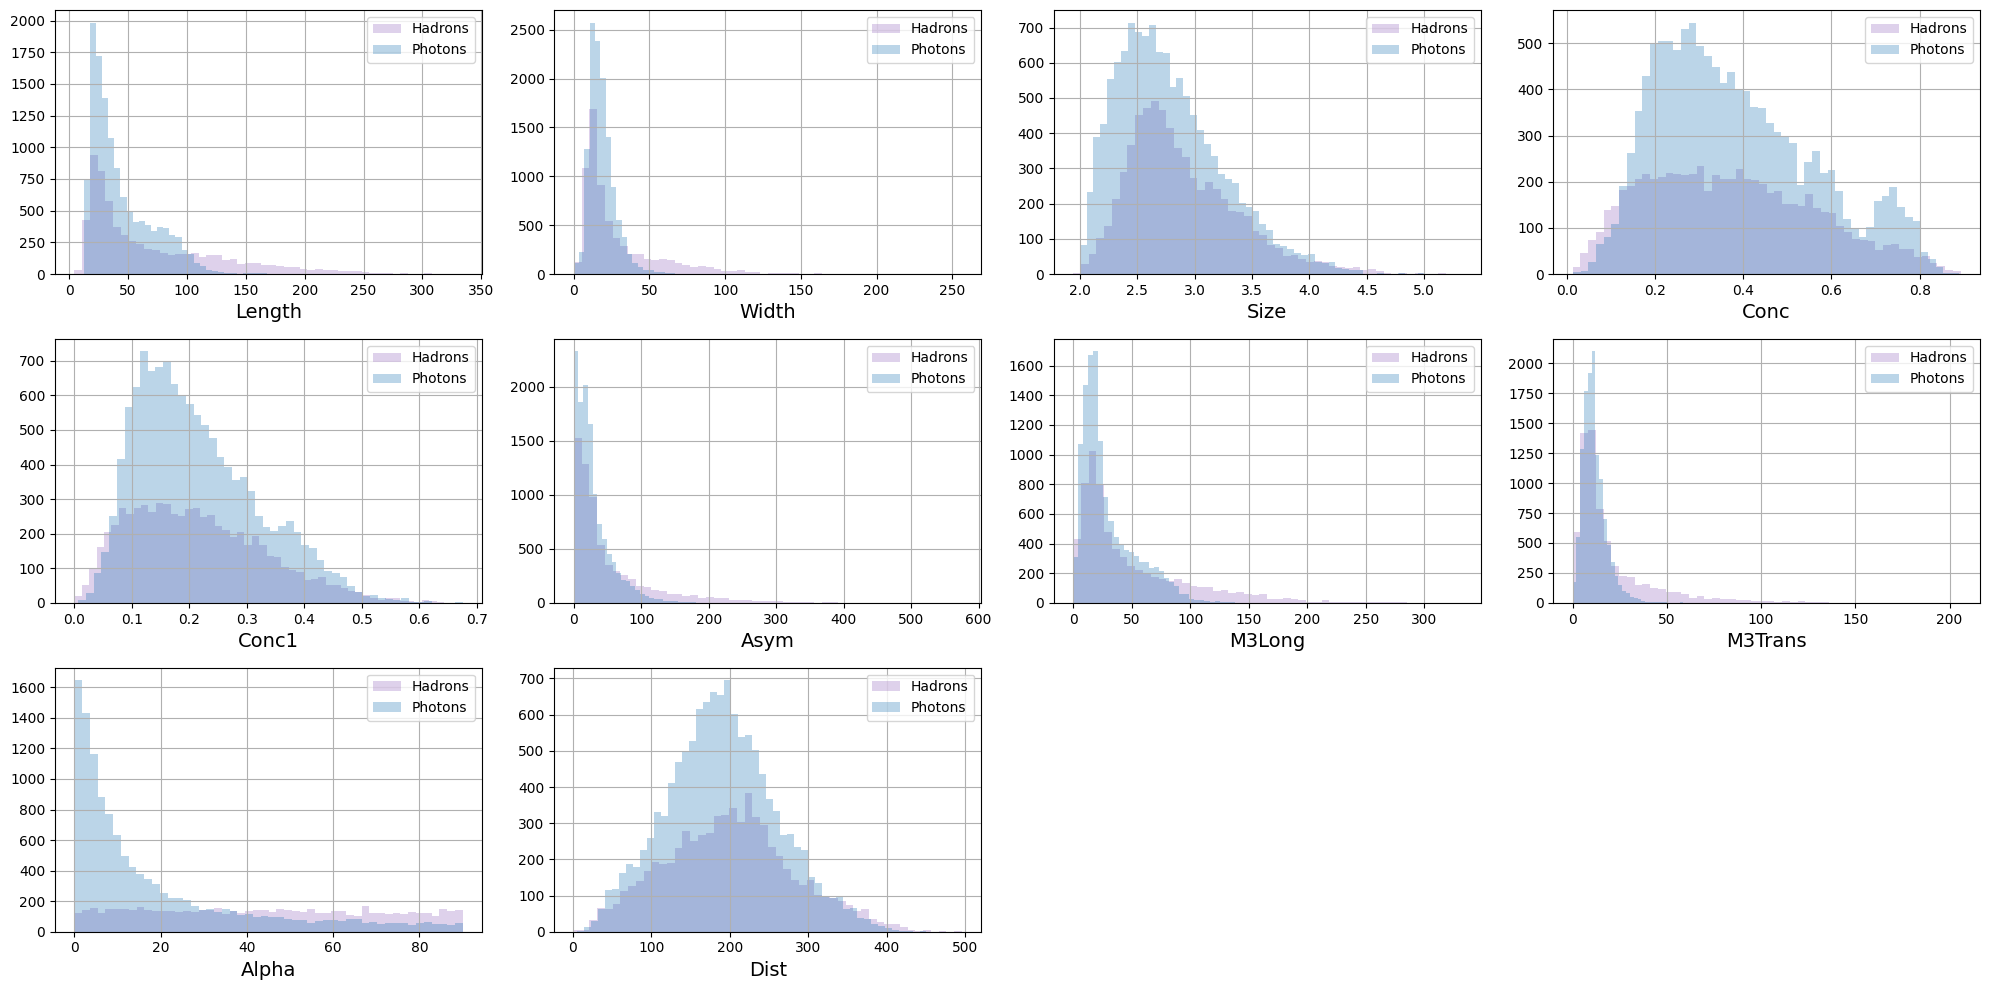

In [8]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

In [9]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify = y, test_size=0.5, shuffle = True, random_state = 11
)

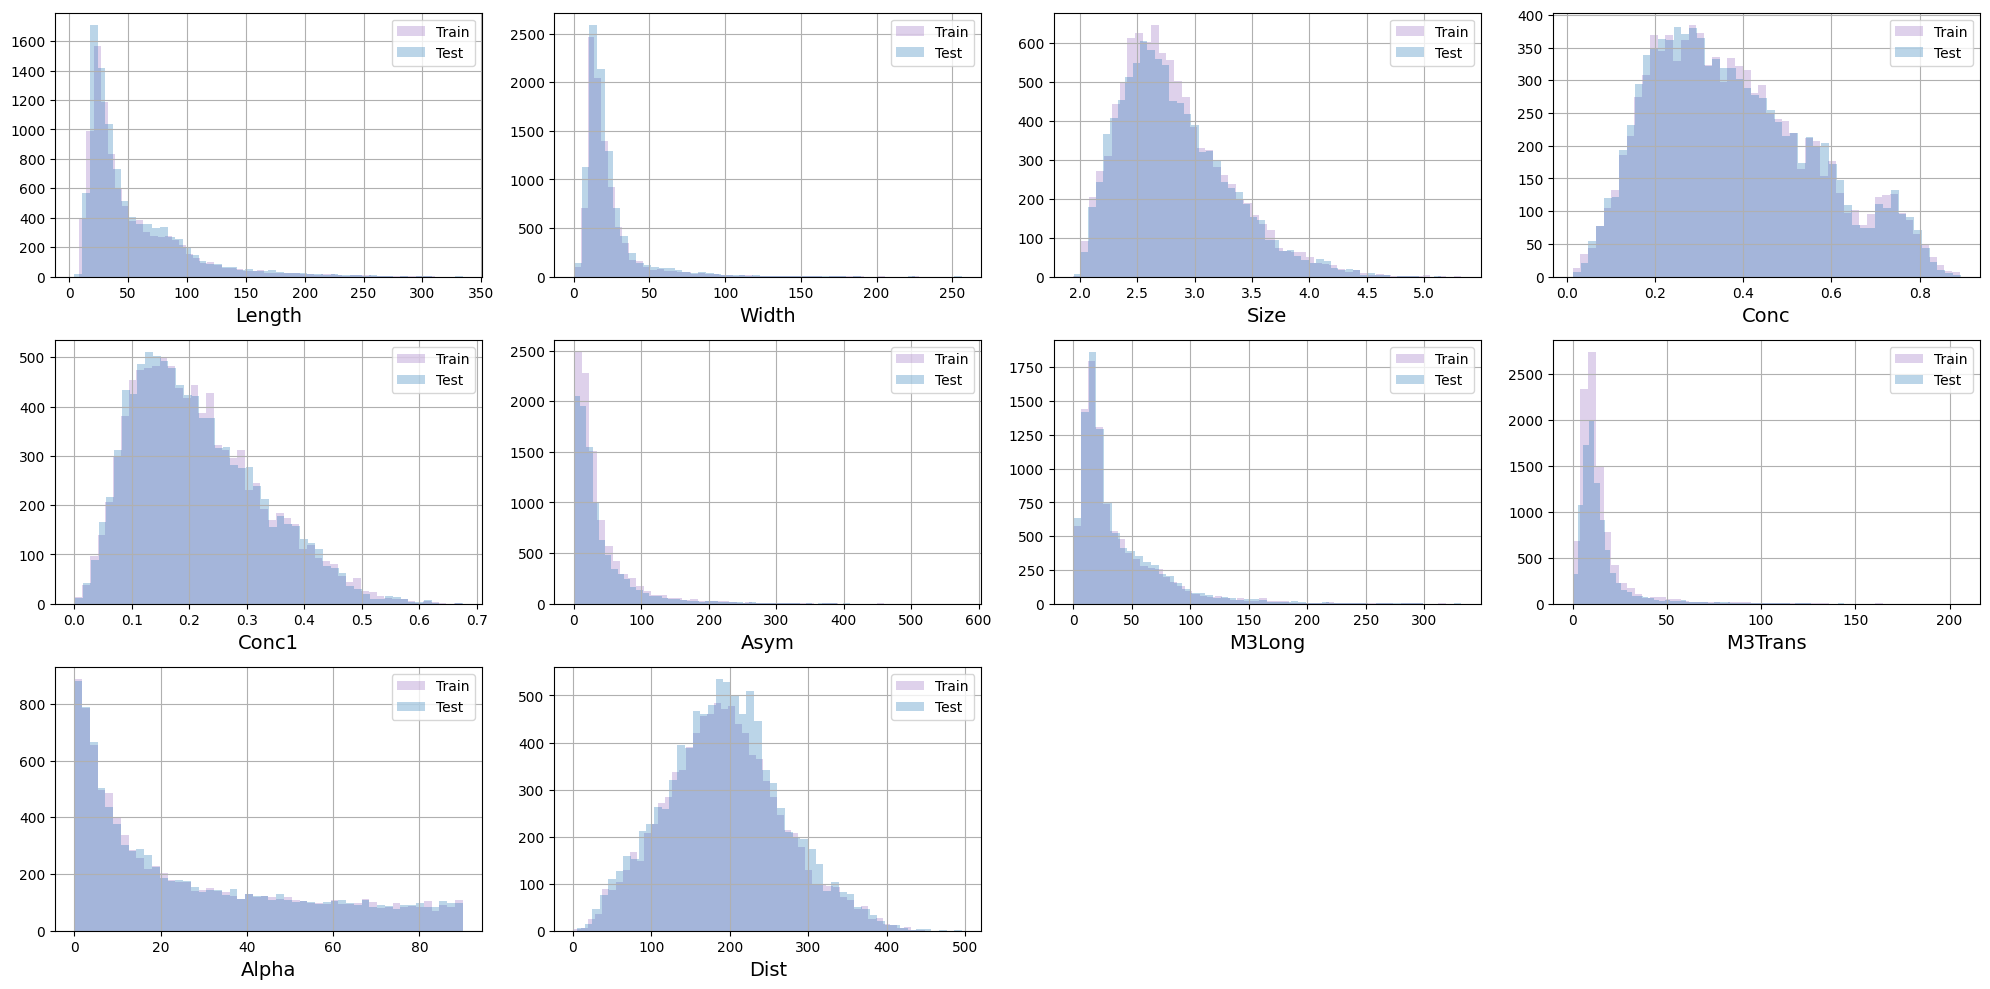

In [10]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test", bins=50)

In [11]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal', random_state=11)

X_train = qt.fit_transform(X_train)
X_test = qt.fit_transform(X_test)

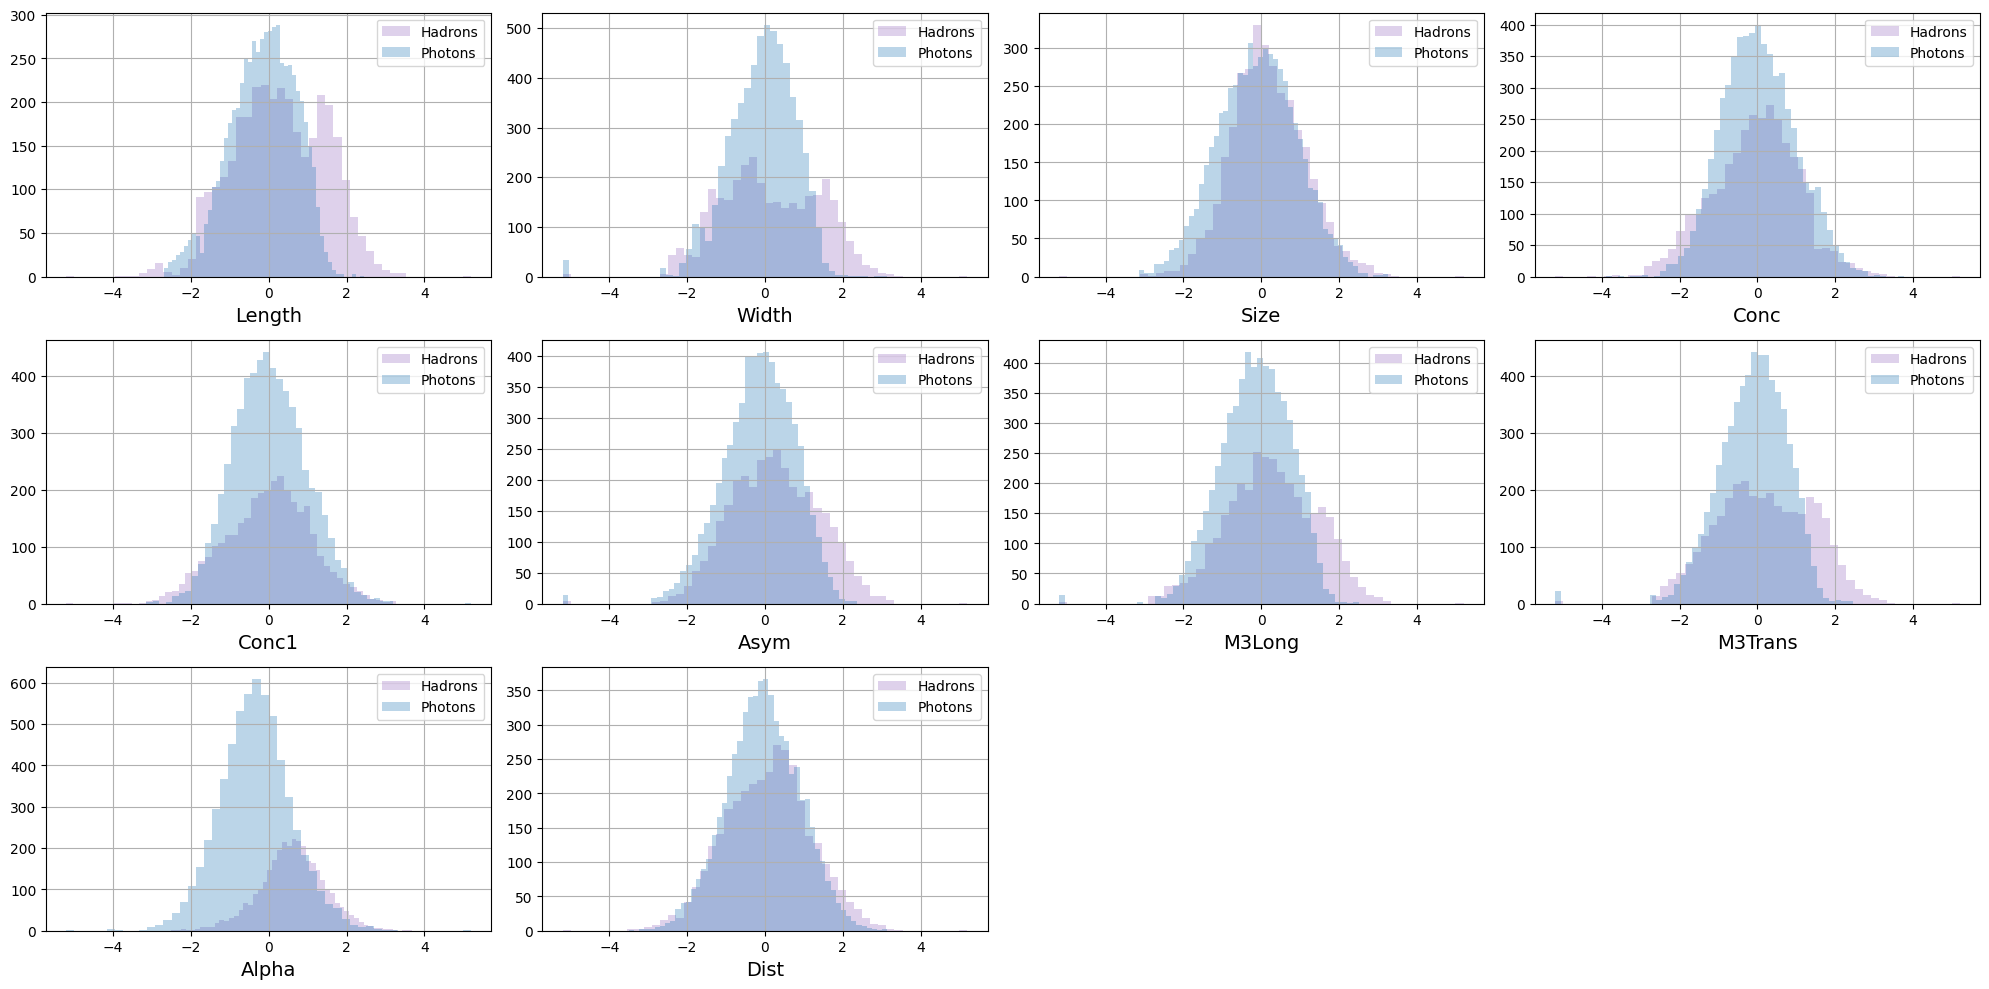

In [12]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

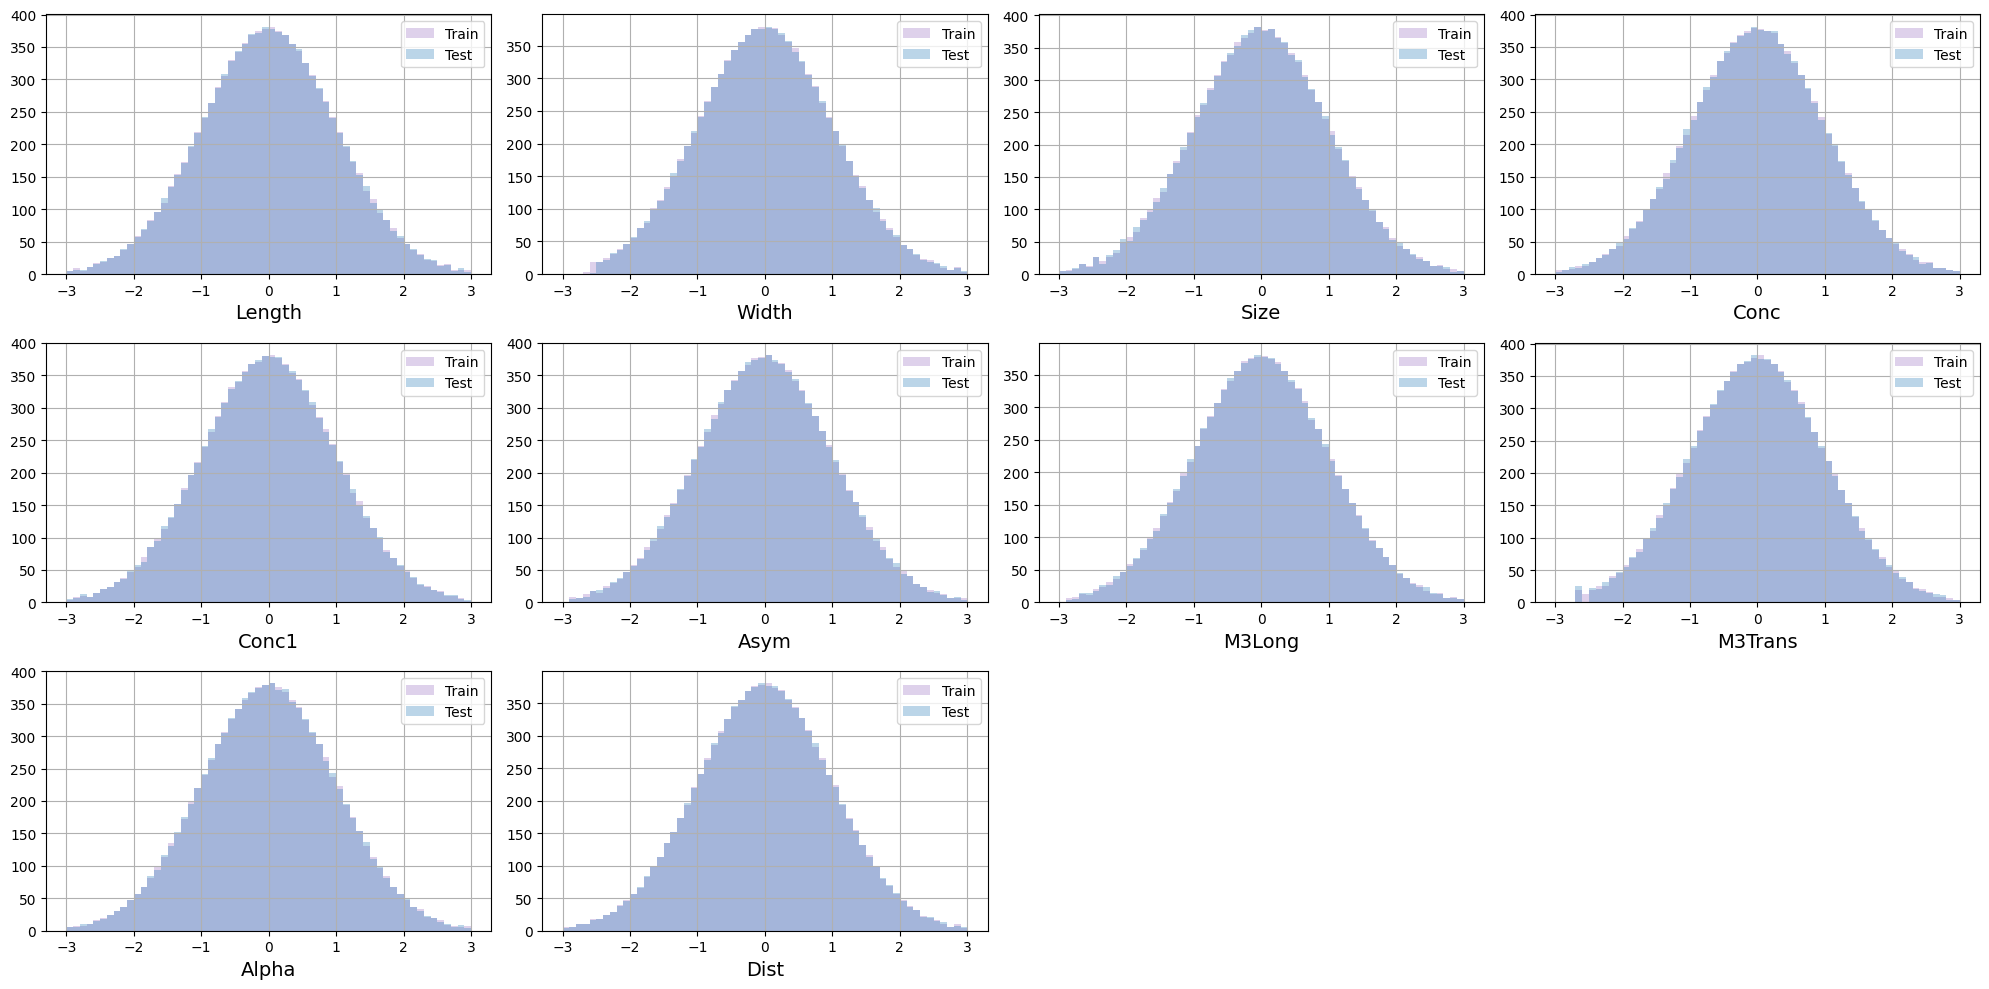

In [13]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Диффузионные модели 

Проведем эксперимент с диффузионной моделью.

`pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118`

In [14]:
#Проверка
import torch

print("CUDA доступна:", torch.cuda.is_available())
print("Версия CUDA:", torch.version.cuda)

CUDA доступна: True
Версия CUDA: 11.8


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
DEVICE

device(type='cuda')

Фукнция для зашумления данных

In [17]:
def corrupt(x, amount):
    x = torch.as_tensor(x, dtype=torch.float32, device=DEVICE)
    amount = torch.as_tensor(amount, dtype=torch.float32, device=DEVICE)

    noise = torch.rand_like(x, device=DEVICE)
    amount = amount.view(-1, 1)
    
    x = x * (1 - amount) + noise * amount
    return x

In [18]:
from diffusers import DDPMScheduler

c:\Users\ksbal\Desktop\HW\GenDL\hw3\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


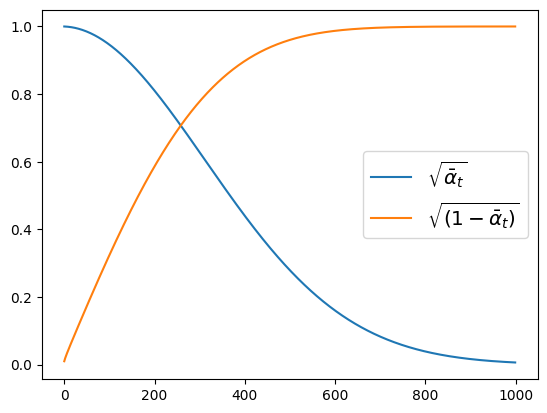

In [19]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large")

Реализация нейронной сети. 

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

В нашем случае для оценки качество можно использовать такие метрики, как ROC‑AUC или Accuracy

In [20]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100), 
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100), 
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs)
        )

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.net(zy)

Функция для генерации нового объекта с помощью обученной модели.

In [21]:
def generate_with_diffusion(model, y, latent_dim, sheduler):
    model.eval()
    device = next(model.parameters()).device

    if isinstance(y, torch.Tensor):
        batch_size = y.shape[0]
        x = torch.randn((batch_size, latent_dim), device=device)
    else:
        batch_size = len(y)
        x = torch.randn((batch_size, latent_dim), device=device)
        y = torch.tensor(y, dtype=torch.float32, device=device)
    
    for t in sheduler.timesteps:
        with torch.no_grad():
            noise_pred = model(x, y)
            x = sheduler.step(noise_pred, t, x).prev_sample
    
    X_fake = x.cpu().numpy()
    return X_fake

Класс обучения диффузионной модели и обучение модели

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

In [23]:
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):
        self.model = model
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)
        self.model.to(DEVICE)

    def _other_agent_score(self, X_real, X_fake, y_real=None):
        XX = np.concatenate((X_fake, X_real), axis=0)
        yy = np.array([0] * len(X_fake) + [1] * len(X_real))

        X_train, X_test, y_train, y_test = train_test_split(
            XX, yy, stratify=yy, test_size=0.25, shuffle=True, random_state=11
        )

        # линейная модель
        lr = LogisticRegression()
        lr.fit(X_train, y_train)
        pred_lr = lr.predict(X_test)
        score_lr = accuracy_score(y_test, pred_lr)

        # градиентный бустинг
        gb = GradientBoostingClassifier()
        gb.fit(X_train, y_train)
        pred_gb = gb.predict(X_test)
        score_gb = accuracy_score(y_test, pred_gb)

        return score_lr, score_gb

    def fit(self, X, y):
        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Инициализация шедулера
        noise_scheduler = DDPMScheduler(
        num_train_timesteps=1000,
        beta_schedule="squaredcos_cap_v2",
        prediction_type="epsilon",
        variance_type="fixed_small",
        clip_sample=True,
        clip_sample_range=3,
        rescale_betas_zero_snr=True,
    )

        # Turn on training
        self.model.train(True)
        loss_fn = nn.MSELoss()
        self.loss_history = []

        # Fit
        for epoch in range(self.n_epochs):
            loss_epoch = 0
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):
                t = torch.randint(0, noise_scheduler.config.num_train_timesteps, (real_batch.size(0),), device=DEVICE)
                noise = torch.randn_like(real_batch)
                noised_x = noise_scheduler.add_noise(real_batch, noise, t)

                pred = self.model(noised_x, cond_batch)
                loss = loss_fn(pred, noise)
                self.opt_gen.zero_grad()
                loss.backward()
                self.opt_gen.step()

                loss_epoch += loss.item()
            self.loss_history.append(loss_epoch / len(dataset_real))

            if (epoch + 1) % 10 == 0:
                idx = np.random.choice(len(X), 1000, replace=False)
                X_real_sample = X[idx]
                y_real_sample = y[idx]
                X_fake = generate_with_diffusion(self.model, y_real_sample, self.latent_dim, noise_scheduler)

                score_lr, score_gb = self._other_agent_score(X_real_sample, X_fake, y_real_sample)
                print(f"Epoch {epoch+1}: loss={loss_epoch:.3f}; LR={score_lr:.3f}; GB={score_gb:.3f}")

        # Turn off training
        self.model.train(False)

In [24]:
%%time
latent_dim = 10
model = DiffusionGenerator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])

diffusionFitter = DiffusionFitter(
    model,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
diffusionFitter.fit(X_train, y_train)

Epoch 10: loss=84.355; LR=0.588; GB=0.692
Epoch 20: loss=78.777; LR=0.522; GB=0.656
Epoch 30: loss=77.078; LR=0.518; GB=0.662
Epoch 40: loss=78.997; LR=0.564; GB=0.642
Epoch 50: loss=76.818; LR=0.588; GB=0.676
Epoch 60: loss=78.380; LR=0.544; GB=0.644
Epoch 70: loss=78.810; LR=0.564; GB=0.634
Epoch 80: loss=77.326; LR=0.516; GB=0.682
Epoch 90: loss=76.496; LR=0.528; GB=0.650
Epoch 100: loss=76.376; LR=0.520; GB=0.632
CPU times: total: 46.9 s
Wall time: 46 s


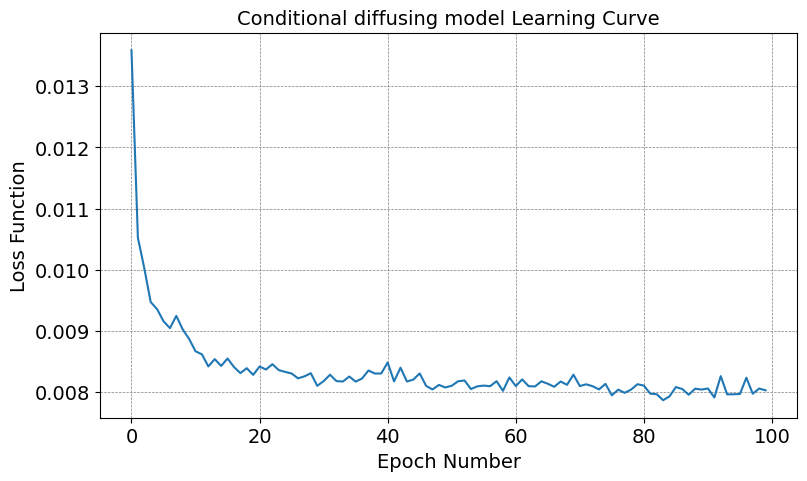

In [25]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(True, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

Генерирую выборку фейковых объектов, равную размеру тестовой выборки, и обучу градиентный бустинг

In [26]:
noise_sheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_schedule="squaredcos_cap_v2",
    prediction_type="epsilon",
    variance_type="fixed_small",
    clip_sample=True,
    clip_sample_range=3,
    rescale_betas_zero_snr=True,
    )

In [27]:
X_fake_test = generate_with_diffusion(
    model=model,
    y=y_test,  
    latent_dim=X_test.shape[1], 
    sheduler=noise_sheduler
)
X_fake_train = generate_with_diffusion(model, y_train, X_train.shape[1], noise_sheduler)

# Убедимся, что размерности совпадают
assert X_fake_test.shape == X_test.shape, f"Shape mismatch: fake {X_fake_test.shape} vs real {X_test.shape}"
assert X_fake_train.shape == X_train.shape, f"Shape mismatch: fake {X_fake_train.shape} vs real {X_train.shape}"

In [28]:
# Объединение трейна
XX_train = np.concatenate([X_fake_train, X_train], axis=0)
yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))

In [29]:
# Объединение для теста
XX_test = np.concatenate([X_fake_test, X_test], axis=0)
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [30]:
from sklearn.metrics import roc_auc_score

clf = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=3,
    random_state=42
)
clf.fit(XX_train, yy_train)

# Предсказания
y_pred = clf.predict(XX_test)
y_proba = clf.predict_proba(XX_test)[:, 1]

# Метрики
auc = roc_auc_score(yy_test, y_proba)
acc = accuracy_score(yy_test, y_pred)

print(f"ROC-AUC = {auc:.3f}")
print(f"Accuracy = {acc:.3f}")

ROC-AUC = 0.763
Accuracy = 0.692


# Потоки 

Диффузия показала себя как достойный конкурент GAN модели. Так как данных не много, обучали не долго, задача не сложная - отличия от GAN не так заметны, но все равно достойные.

Для Diffusion получили ROC AUC около 0.76. Попробуем обучить RealNVP для решения этой задачи.


In [31]:
trainloader = torch.utils.data.DataLoader(X_train, batch_size=64, shuffle=True)

In [32]:
# Main class for NormFlow
class NormalizingFlow(nn.Module):

    def __init__(self, layers, prior):
        super(NormalizingFlow, self).__init__()
        self.layers = nn.ModuleList(layers)  
        self.prior = prior

        # your code below

    def log_prob(self, x):
        log_likelihood = None

        for layer in self.layers:
            x, change = layer.f(x)
            if log_likelihood is not None:
                log_likelihood = log_likelihood + change
            else:
                log_likelihood = change

        log_likelihood = log_likelihood + self.prior.log_prob(x)

        return log_likelihood.mean()

    def sample(self, num_samples):
        x = self.prior.sample((num_samples, ))

        for layer in self.layers[::-1]:
            x = layer.g(x)

        return x

Реализация нейронной сети RealNVP

- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

In [42]:
class RealNVP(nn.Module):
    def __init__(self, var_size, mask, hidden=100):
        super(RealNVP, self).__init__()
        self.mask = mask
        self.var_size = var_size

        mask_sum = int(self.mask.sum().item())
        mask_diff = var_size - mask_sum

        self.nn_t = nn.Sequential(
            nn.Linear(mask_sum, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, mask_diff)
        )
        
        self.nn_s = nn.Sequential(
            nn.Linear(mask_sum, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, mask_diff)
        )

    def f(self, x):
        mask = self.mask.to(x.device)

        x1 = x * mask     
        x2 = x * (1 - mask)  

        x1_for_net = x1[:, mask.bool()]  

        t = self.nn_t(x1_for_net)  
        s = self.nn_s(x1_for_net) 

        s = torch.tanh(s)

        x2_transformed = x2[:, (1 - mask).bool()] * torch.exp(s) + t  
        new_x = x.clone()
        new_x[:, (1 - mask).bool()] = x2_transformed
        log_det = torch.sum(s, dim=1)

        return new_x, log_det

    def g(self, x):
        mask = self.mask.to(x.device)

        x1 = x * mask
        x2 = x * (1 - mask)

        x1_for_net = x1[:, mask.bool()]

        t = self.nn_t(x1_for_net)
        s = self.nn_s(x1_for_net)

        x2_original = (x2[:, (1 - mask).bool()] - t) * torch.exp(-s)

        new_x = x.clone()
        new_x[:, (1 - mask).bool()] = x2_original

        return new_x

In [43]:
def train_nf(tr_dataloader, nf, opt, num_epochs):
    nf.train()
    loss_trace = []

    iter_i = 0

    for epoch_i in range(num_epochs):
        print(f'Epoch {epoch_i + 1}')
        for batch in tr_dataloader:

            x = batch.float()

            opt.zero_grad()

            loss = -nf.log_prob(x)
            loss.backward()

            opt.step()

            loss_trace.append((iter_i, loss.item()))

            iter_i += 1
    return loss_trace

In [44]:
prior = torch.distributions.MultivariateNormal(torch.zeros(10), torch.eye(10))

layers = []
for i in range(4):
    layers.append(RealNVP(var_size=10, mask=((torch.arange(10) + i) % 2)))

nf = NormalizingFlow(layers=layers,
                    prior=prior)

opt = torch.optim.Adam(nf.parameters(), lr=1e-3)

In [45]:
train_nf(trainloader, nf, opt, num_epochs=10)

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10


[(0, 16.738983154296875),
 (1, 14.42828369140625),
 (2, 13.837699890136719),
 (3, 13.55673885345459),
 (4, 13.658740043640137),
 (5, 14.181838989257812),
 (6, 13.288209915161133),
 (7, 12.427192687988281),
 (8, 12.897196769714355),
 (9, 12.538570404052734),
 (10, 12.416181564331055),
 (11, 12.842764854431152),
 (12, 12.211715698242188),
 (13, 11.590240478515625),
 (14, 11.593904495239258),
 (15, 12.130294799804688),
 (16, 11.677776336669922),
 (17, 11.652216911315918),
 (18, 11.225987434387207),
 (19, 11.668512344360352),
 (20, 10.977762222290039),
 (21, 11.220873832702637),
 (22, 10.790477752685547),
 (23, 10.453035354614258),
 (24, 10.897919654846191),
 (25, 10.966619491577148),
 (26, 10.27564811706543),
 (27, 10.252915382385254),
 (28, 9.867291450500488),
 (29, 9.872661590576172),
 (30, 9.6900634765625),
 (31, 9.270539283752441),
 (32, 10.146871566772461),
 (33, 9.98270034790039),
 (34, 9.88365364074707),
 (35, 9.130470275878906),
 (36, 9.402135848999023),
 (37, 9.631863594055176),


Генерируем выборку фейковых объектов, равную размеру тестовой выборки, и обучаем градиентный бустинг

In [46]:
X_fake_test = nf.sample(num_samples=len(X_test)).detach().cpu().numpy()
X_fake_train = nf.sample(num_samples=len(X_train)).detach().cpu().numpy()

# Убедимся, что размерности совпадают
assert X_fake_test.shape == X_test.shape, f"Test shape mismatch: fake {X_fake_test.shape} vs real {X_test.shape}"
assert X_fake_train.shape == X_train.shape, f"Train shape mismatch: fake {X_fake_train.shape} vs real {X_train.shape}"

In [47]:
XX_train = np.concatenate([X_fake_train, X_train], axis=0)
yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))

XX_test = np.concatenate([X_fake_test, X_test], axis=0)
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [48]:
clf = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=3,
    random_state=42
)
clf.fit(XX_train, yy_train)

y_pred = clf.predict(XX_test)
y_proba = clf.predict_proba(XX_test)[:, 1]

auc = roc_auc_score(yy_test, y_proba)
acc = accuracy_score(yy_test, y_pred)

print(f"RealNVP — ROC-AUC = {auc:.3f}")
print(f"RealNVP — Accuracy = {acc:.3f}")

RealNVP — ROC-AUC = 0.689
RealNVP — Accuracy = 0.630
